# Pre-Processing Pipeline

**Author:** Felipe Cortes Jaramillo

**Description:** Pre-processing pipeline for text translation.

**References:** https://github.com/tommytracey/AIND-Capstone/blob/master/machine_translation.ipynb

## Installing Packages and Downloading Data:

In [33]:
# Install Hugging Face Library for Datasets
!pip install datasets pandas nltk clean-text

In [34]:
# Import needed libraries
import pandas as pd
import numpy as np
from datasets import load_dataset

import nltk
from cleantext import clean
from nltk.tokenize import word_tokenize

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, GRU, LSTM, Bidirectional, Dropout, Input, Dense, Conv1D, MaxPool1D, Conv1DTranspose
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
#from sklearn.model_selection import train_test_split

In [5]:
# Check if TensorFlow is able to detect the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to use only one GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Enable memory growth
        tf.config.experimental.set_memory_growth(gpus[0], True)

        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        # Memory growth must be set at program startup
        print("RuntimeError:", e)
else:
    raise SystemError("GPU device not found")

SystemError: GPU device not found

In [6]:
# Extract dataset
translation_dataset = load_dataset('Nicolas-BZRD/Parallel_Global_Voices_English_French',
                                   split='train').to_pandas()
translation_dataset.head(5)

,en,fr
0,Jamaica: “I am HIV”,Jamaïque : J’ai le VIH
1,"It's widely acknowledged, in the Caribbean and...","Il est largement reconnu, dans les Caraïbes et..."
2,"For this woman, however, photographed in the s...","Pour cette femme, cependant, photographiée dan..."
3,As Bacon writes on her blog:,Comme Bacon écrit sur son blog:
4,"“When I asked to take her picture, I suggested...",“Quand je lui ai demandé de la prendre en phot...


In [7]:
# Remove line when finishied (OPTIONAL)
df = translation_dataset.head(8060)

## Data Pre-processing:

In [8]:
# First step - Data Pre-processing

# nltk downloads
nltk.download('punkt')

# Define a cleaning function
def clean_text(text):
    return clean(text,
                 fix_unicode=True,               # fix various unicode errors
                 to_ascii=True,                  # transliterate to closest ASCII representation
                 lower=True,                     # lowercase text
                 no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
                 no_urls=True,                   # replace all URLs with a special token
                 no_emails=True,                 # replace all email addresses with a special token
                 no_phone_numbers=True,          # replace all phone numbers with a special token
                 no_numbers=False,               # replace all numbers with a special token
                 no_digits=False,                # replace all digits with a special token
                 no_currency_symbols=True,       # replace all currency symbols with a special token
                 no_punct=True,                  # remove punctuations
                 replace_with_punct="",          # replace punctuations with this character
                 replace_with_url="<URL>",
                 replace_with_email="<EMAIL>",
                 replace_with_phone_number="<PHONE>",
                 replace_with_number="<NUMBER>",
                 replace_with_digit="<DIGIT>",
                 replace_with_currency_symbol="<CUR>",
                 lang="en")

# Apply cleaning function to both English and French columns
df['en'] = df['en'].apply(clean_text)
df['fr'] = df['fr'].apply(clean_text)

# Tokenization
df['en_tokens'] = df['en'].apply(word_tokenize)
df['fr_tokens'] = df['fr'].apply(word_tokenize)

# Handling missing data
df.dropna(subset=['en', 'fr'], inplace=True)

# Save the preprocessed data
df.to_csv('preprocessed_data.csv', index=False)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/schaefer.bastian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/p9/q_n4s9cj6m15m7f_8tvsd0380000gn/T/ipykernel_15888/1249602603.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['en'] = df['en'].apply(clean_text)
/var/folders/p9/q_n4s9cj6m15m7f_8tvsd0380000gn/T/ipykernel_15888/1249602603.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fr'] = df['fr'].apply(clean_text)
/var/folders/p9/q_n4s9cj6m15m7f_8

In [9]:
# Second step - Data Transformation for Training

# Tokenization
tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(df['en_tokens'])
tokenizer_fr = Tokenizer()
tokenizer_fr.fit_on_texts(df['fr_tokens'])

# Convert text to sequences
sequences_en = tokenizer_en.texts_to_sequences(df['en_tokens'])
sequences_fr = tokenizer_fr.texts_to_sequences(df['fr_tokens'])

# Padding sequences
max_len = max(max(len(s) for s in sequences_en), max(len(s) for s in sequences_fr))
sequences_en = pad_sequences(sequences_en, maxlen=max_len, padding='post')
sequences_fr = pad_sequences(sequences_fr, maxlen=max_len, padding='post')

# Splitting the data
split = int(len(sequences_en) * 0.8)
trainX, testX = sequences_en[:split], sequences_en[split:]
trainY, testY = sequences_fr[:split], sequences_fr[split:]


In [10]:
# Third step - Reshape data for feeding into model (French words)
trainY = trainY.reshape(trainY.shape[0], trainY.shape[1], 1)
testY = testY.reshape(testY.shape[0], testY.shape[1], 1)

In [11]:
# Fourth Step - Some relevant information after pre-processing and transforming
max_english_sequence_length = sequences_en.shape[1]
max_french_sequence_length = sequences_fr.shape[1]
english_vocab_size = len(tokenizer_en.word_index)
french_vocab_size = len(tokenizer_fr.word_index)

print('<--- Data Preprocessed Summary: --->')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

<--- Data Preprocessed Summary: --->
Max English sentence length: 121
Max French sentence length: 121
English vocabulary size: 16633
French vocabulary size: 20821


----------------------------------------------------------

In [12]:
# Testing Module - Models

def translate_sequence(seq, tokenizer):
    """ Translates a sequence of integers back into text using the tokenizer. """
    words = [tokenizer.index_word.get(idx, '') for idx in seq]
    return ' '.join(words).strip()

def predict_and_compare(index, testX, model, tokenizer_en, tokenizer_fr):
    """ Predicts translation for a given index in the test set and compares with the ground truth. """
    input_seq = testX[index:index+1]
    prediction = model.predict(input_seq)

    # Converting the prediction to a sequence of integers
    predicted_seq = np.argmax(prediction, axis=-1)[0]

    # Reverse tokenization (converting sequences back to words)
    input_text = translate_sequence(input_seq[0], tokenizer_en)
    predicted_text = translate_sequence(predicted_seq, tokenizer_fr)
    ground_truth_text = translate_sequence(testY[index].flatten(), tokenizer_fr)

    print("Input (English):", input_text)
    print("Predicted (French):", predicted_text)
    print("Ground Truth (French):", ground_truth_text)

In [41]:
# Model Section - First Model RNN

def simple_cnn(tokenizer_en, tokenizer_fr):

  # Define structure of the model
  model = Sequential()
  model.add(Embedding(input_dim=len(tokenizer_en.word_index) + 1, output_dim=64, input_length=max_len))
  model.add(Conv1D(64, kernel_size=1))
  model.add(MaxPool1D(pool_size=1))
  model.add(Conv1D(128, kernel_size=1))
  model.add(MaxPool1D(pool_size=1))
  model.add(Conv1D(64, kernel_size=1))
  #model.add(MaxPool1D(pool_size=1))
  model.add(Dense(len(tokenizer_fr.word_index) + 1, activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [42]:
%%time

# Testing simple RNN

simple_cnn_instance = simple_cnn(tokenizer_en=tokenizer_en, tokenizer_fr=tokenizer_fr)
simple_cnn_instance.fit(trainX, trainY, epochs=10, validation_data=(testX, testY), batch_size=64)

Epoch 1/10
101/101 [==============================] - 67s 666ms/step - loss: 3.8135 - accuracy: 0.8170 - val_loss: 1.5406 - val_accuracy: 0.8247
Epoch 2/10
101/101 [==============================] - 71s 703ms/step - loss: 1.4559 - accuracy: 0.8253 - val_loss: 1.5310 - val_accuracy: 0.8247
Epoch 3/10
101/101 [==============================] - 73s 728ms/step - loss: 1.4417 - accuracy: 0.8253 - val_loss: 1.5374 - val_accuracy: 0.8247
Epoch 4/10
101/101 [==============================] - 80s 793ms/step - loss: 1.4370 - accuracy: 0.8253 - val_loss: 1.5441 - val_accuracy: 0.8247
Epoch 5/10
101/101 [==============================] - 82s 817ms/step - loss: 1.4335 - accuracy: 0.8253 - val_loss: 1.5479 - val_accuracy: 0.8246
Epoch 6/10
101/101 [==============================] - 77s 767ms/step - loss: 1.4299 - accuracy: 0.8253 - val_loss: 1.5479 - val_accuracy: 0.8246
Epoch 7/10
101/101 [==============================] - 81s 800ms/step - loss: 1.4253 - accuracy: 0.8253 - val_loss: 1.5456 - val_ac

In [43]:
# Predicting with simple RNN (First 3 Test Samples)
for i in range(3):
    predict_and_compare(index=i, testX=testX, model=simple_cnn_instance, tokenizer_en=tokenizer_en, tokenizer_fr=tokenizer_fr)

1/1 [==============================] - 0s 90ms/step
Input (English): do you believe uganda has a free press
Predicted (French): de de de  de de de de
Ground Truth (French): croyezvous que louganda a une presse libre
1/1 [==============================] - 0s 13ms/step
Input (English): a for the moment the traditional media are basically safe at least until the end of the commonwealth heads of government meeting in november
Predicted (French): de de de de de de de de de  de de  de de de de de  de de de de q
Ground Truth (French): a pour le moment les media traditionnels sont saufs au moins jusqua la fin de la reunion des chefs de gouvernement du commonwealth en novembre
1/1 [==============================] - 0s 14ms/step
Input (English): but the cracks have already started to appear with upcountry radio stations in places like the toro region in western uganda being harassed for all kinds of things
Predicted (French): de de de de de de de  de de   de  de de de  de de  de de de de de de d

____________________________________________________________

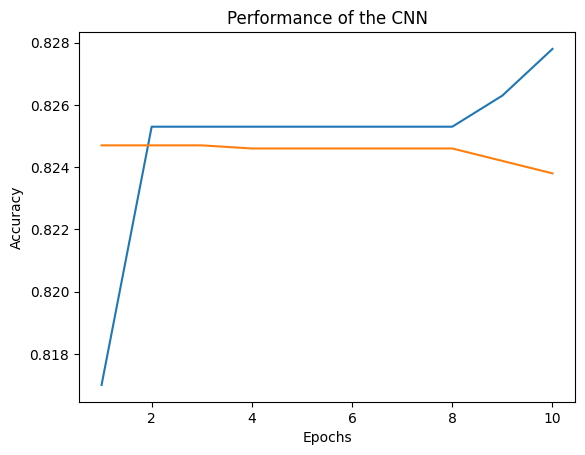

In [49]:
# Plot Accuracy
import matplotlib.pyplot as plt

accuracy = [0.8170, 0.8253, 0.8253, 0.8253, 0.8253, 0.8253, 0.8253, 0.8253, 0.8263, 0.8278]
val_accuracy = [0.8247, 0.8247, 0.8247, 0.8246, 0.8246, 0.8246, 0.8246, 0.8246, 0.8242, 0.8238]
test_accuracy = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, ax = plt.subplots()
ax.plot(epochs, accuracy)
ax.plot(epochs, val_accuracy)
plt.title("Performance of the CNN")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# End of notebook